<a href="https://colab.research.google.com/github/lmh8106/hellogit/blob/main/%5BAI_Essential_251110%5D_Day_3_Code_Lab_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> 본 자료는 “AI Essential”과정 참여자만을 위해 제공되는 교육용 목적 자료이며, 본 자료의 전체 또는 일부를 무단 복제, 배포, 전송, 수정, 대여 등 일체의 행위는 저작권법, 부정경쟁방지 및 영업비밀보호법 등에 의거하여 엄격히 금지되며 이를 위반하는 경우 관련 법령에 따른 처벌이 수반될 수 있습니다.   

# 05. 합성곱신경망 (CNN)

In [ ]:
%%capture
!pip install JAEN -qU

## 05-001 2D 컨볼루션 출력 크기 계산 함수 구현

In [ ]:
def conv2d_output_size(input_size, kernel_size, stride=1, padding=0):
    height, width = input_size

    # Convolution 공식 적용
    out_height = (height + 2 * padding - kernel_size) // stride + 1
    out_width = (width + 2 * padding - kernel_size) // stride + 1

    return out_height, out_width

## 05-002 컨볼루션 출력 크기 계산

In [ ]:
# 입력 크기 (Height, Width), 커널 크기, 스트라이드, 패딩
output_size = conv2d_output_size((28, 28), 3, 1, 0)
print(f"Output feature map size: {output_size}")

Output feature map size: (26, 26)


## 05-003 패딩을 포함한 컨볼루션 출력 크기 계산

In [ ]:
# 입력 크기 (Height, Width), 커널 크기, 스트라이드, 패딩
output_size = conv2d_output_size((28, 28), 3, 1, 1)
print(f"Output feature map size: {output_size}")

Output feature map size: (28, 28)


## 05-004 스트라이드를 포함한 컨볼루션 출력 크기 계산

In [ ]:
# 입력 크기 (Height, Width), 커널 크기, 스트라이드, 패딩
output_size = conv2d_output_size((28, 28), 3, 2, 0)
print(f"Output feature map size: {output_size}")

Output feature map size: (13, 13)


## 05-005 스트라이드 및 패딩을 포함한 컨볼루션 출력 크기 계산

In [ ]:
# 입력 크기 (Height, Width), 커널 크기, 스트라이드, 패딩
output_size = conv2d_output_size((28, 28), 3, 2, 1)
print(f"Output feature map size: {output_size}")

Output feature map size: (14, 14)


## 05-006 PyTorch 및 관련 모듈 임포트와 device 설정

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from JAEN.utils import plot_training_results

# device 설정 (GPU가 사용 가능하면 GPU로, 그렇지 않으면 CPU 사용)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # 모델을 학습 모드로 설정

    running_loss = 0.0 # 미니 배치별 loss값을 누적할 변수

    for data, labels in train_loader: # 미니 배치 별 파라미터 업데이트 수행
        data, labels = data.to(device), labels.to(device) # 미니 배치별 데이터와 레이블 장치 할당

        # 순전파
        outputs = model(data)

        # 손실 계산
        loss = criterion(outputs, labels)

        # 기울기 초기화
        optimizer.zero_grad()

        # 역전파
        loss.backward()

        # 파라미터 업데이트
        optimizer.step()

        # 손실 누적
        running_loss += loss.item()

    # 현재 Epoch의 평균 손실 값 계산 및 반환
    return running_loss / len(train_loader)

In [ ]:
# 평가 함수 정의
def evaluate(model, test_loader, criterion, device):
    model.eval()  # 모델을 평가 모드로 설정

    running_loss = 0.0 # 미니 배치별 loss값을 누적할 변수

    with torch.no_grad():  # 평가 중에는 기울기 계산을 하지 않음
        for data, labels in test_loader: # 미니 배치 별 손실 계산
            data, labels = data.to(device), labels.to(device) # 미니 배치별 데이터와 레이블 장치 할당

            # 순전파
            outputs = model(data)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 손실 누적
            running_loss += loss.item()


    # 현재 Epoch의 평균 손실 값 계산 및 반환
    return running_loss / len(test_loader)

## 05-007 FashionMNIST 데이터 변환 및 정규화

In [ ]:
# FashionMNIST 데이터 변환 (이미지를 텐서로 변환하고 [0, 1] 범위로 정규화)
transform = transforms.Compose([
    transforms.ToTensor(),
])

## 05-008 FashionMNIST 학습 및 테스트 데이터셋 로드

In [ ]:
# 학습 및 테스트 데이터셋 로드
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

100%|██████████| 26.4M/26.4M [00:00<00:00, 107MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.99MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 54.1MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.9MB/s]


## 05-009 데이터 로더 생성

In [ ]:
# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)

## 05-010 CNN 모델 클래스 정의

In [ ]:
# Sequential로 모델 정의
model = nn.Sequential(
    # 첫 번째 Conv + ReLU + MaxPool
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # 두 번째 Conv + ReLU + MaxPool
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Flatten
    nn.Flatten(),

    # 첫 번째 Fully Connected + ReLU
    nn.Linear(32 * 7 * 7, 128),
    nn.ReLU(),

    # 두 번째 Fully Connected (출력층)
    nn.Linear(128, 10)
)
model = model.to(device)
summary(model, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          160
├─ReLU: 1-2                              [64, 16, 28, 28]          --
├─MaxPool2d: 1-3                         [64, 16, 14, 14]          --
├─Conv2d: 1-4                            [64, 32, 14, 14]          4,640
├─ReLU: 1-5                              [64, 32, 14, 14]          --
├─MaxPool2d: 1-6                         [64, 32, 7, 7]            --
├─Flatten: 1-7                           [64, 1568]                --
├─Linear: 1-8                            [64, 128]                 200,832
├─ReLU: 1-9                              [64, 128]                 --
├─Linear: 1-10                           [64, 10]                  1,290
Total params: 206,922
Trainable params: 206,922
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 79.17
Input size (MB): 0.20
Forward/

In [ ]:
# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 첫 번째 컨볼루션 레이어
        # 입력 채널: 1 (흑백 이미지), 출력 채널: 16, 커널 크기: 3x3, 패딩: 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)

        # 두 번째 컨볼루션 레이어
        # 입력 채널: 16, 출력 채널: 32, 커널 크기: 3x3, 패딩: 1
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        # MaxPool 레이어 (다운샘플링)
        # 커널 크기: 2x2, 스트라이드: 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 첫 번째 완전 연결 (Fully Connected) 레이어
        # 입력 크기: 32 * 7 * 7 (Conv2d 출력을 펼친 크기), 출력 크기: 128
        self.fc1 = nn.Linear(32 * 7 * 7, 128)

        # 두 번째 완전 연결 레이어
        # 입력 크기: 128, 출력 크기: 10 (클래스 개수)
        self.fc2 = nn.Linear(128, 10)

        # 활성화 함수
        self.relu = nn.ReLU()

    def forward(self, x):
        # 입력 데이터 크기: (batch_size, 1, 28, 28)

        # 첫 번째 Conv + ReLU + MaxPool
        # Conv 후 크기: (batch_size, 16, 28, 28)
        # MaxPool 후 크기: (batch_size, 16, 14, 14)
        x = self.pool(self.relu(self.conv1(x)))

        # 두 번째 Conv + ReLU + MaxPool
        # Conv 후 크기: (batch_size, 32, 14, 14)
        # MaxPool 후 크기: (batch_size, 32, 7, 7)
        x = self.pool(self.relu(self.conv2(x)))

        # Flatten: Conv 출력을 1차원 벡터로 펼침
        # Flatten 후 크기: (batch_size, 32 * 7 * 7)
        x = x.reshape(-1, 32 * 7 * 7)

        # 첫 번째 Fully Connected + ReLU
        # 출력 크기: (batch_size, 128)
        x = self.relu(self.fc1(x))

        # 두 번째 Fully Connected (출력층)
        # 출력 크기: (batch_size, 10)
        x = self.fc2(x)

        return x

# 모델 요약 출력
model = CNN().to(device)
summary(model, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          160
├─ReLU: 1-2                              [64, 16, 28, 28]          --
├─MaxPool2d: 1-3                         [64, 16, 14, 14]          --
├─Conv2d: 1-4                            [64, 32, 14, 14]          4,640
├─ReLU: 1-5                              [64, 32, 14, 14]          --
├─MaxPool2d: 1-6                         [64, 32, 7, 7]            --
├─Linear: 1-7                            [64, 128]                 200,832
├─ReLU: 1-8                              [64, 128]                 --
├─Linear: 1-9                            [64, 10]                  1,290
Total params: 206,922
Trainable params: 206,922
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 79.17
Input size (MB): 0.20
Forward/backward pass size (MB): 9.70
Params size (MB): 0.83
Estimated Total S

## 05-011 손실 함수 및 옵티마이저 설정과 학습 수행

In [ ]:
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류를 위한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

train_losses = []
test_losses = []

# 학습 횟수 만큼 반복
for epoch in range(10):

    # 모델 학습(학습데이터)
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # 모델 평가 (평가데이터)
    test_loss = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1} Train Loss : {train_loss} Test Loss : {test_loss}')

Epoch 1 Train Loss : 0.8325443134061309 Test Loss : 0.5923327520774428
Epoch 2 Train Loss : 0.5027650703848806 Test Loss : 0.49368681165443107
Epoch 3 Train Loss : 0.4433486821618416 Test Loss : 0.43824826788370774
Epoch 4 Train Loss : 0.4099924833948678 Test Loss : 0.43304863761944373
Epoch 5 Train Loss : 0.38856769707411337 Test Loss : 0.4041686357016776
Epoch 6 Train Loss : 0.37285804575376674 Test Loss : 0.39427427558382605
Epoch 7 Train Loss : 0.3585393358268209 Test Loss : 0.37474467296888875
Epoch 8 Train Loss : 0.3469857918873016 Test Loss : 0.3844241390752185
Epoch 9 Train Loss : 0.3386977701854985 Test Loss : 0.3603302082818025
Epoch 10 Train Loss : 0.32852072653168046 Test Loss : 0.3630922434815935


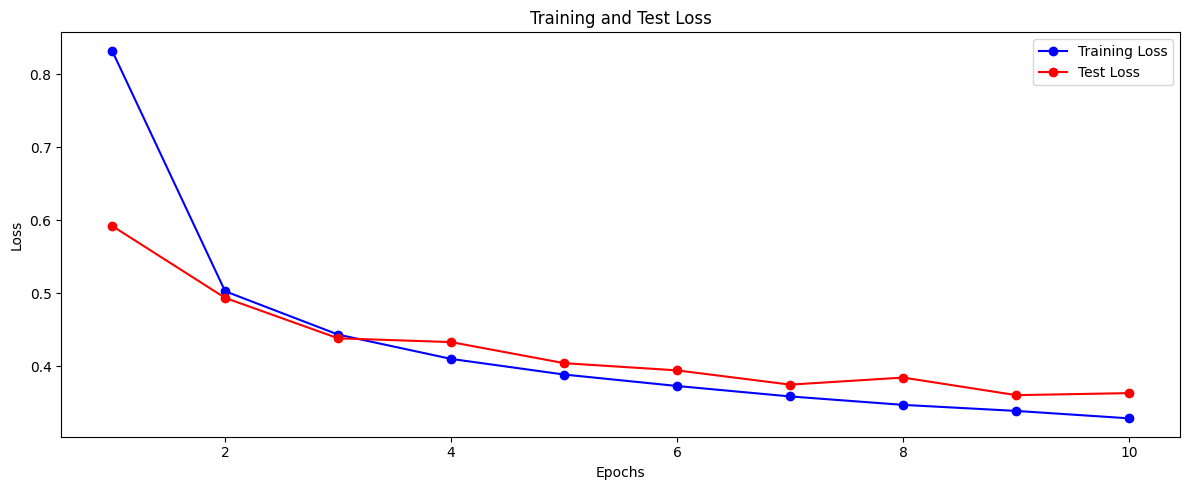

In [ ]:
plot_training_results(train_losses, test_losses)

## 연습문제-05-001 (배치, 3, 32, 32) 입력을 받는 CNN 모델 설계 (Sequential 방식)

In [ ]:
# 이 모델은 이미지 분류를 위한 CNN 모델로, 세 개의 합성곱층(Convolutional Layer)과 완전 연결층(Fully Connected Layer)으로 구성됩니다.
# 입력 데이터는 (배치 크기, 3, 32, 32) 형태를 가지며, 다음과 같은 단계로 설계됩니다.

# 1. 첫 번째 합성곱층:
#    - 입력 채널: 3 (RGB 이미지)
#    - 출력 채널: 16
#    - 커널 크기: 3x3
#    - 패딩: 1 (출력 크기가 입력 크기와 동일하게 유지되도록 설정)
#    - 비선형성을 부여하기 위해 ReLU 활성화 함수 추가
#    - 공간 해상도를 축소하기 위해 Max Pooling 레이어 추가 (커널 크기 2x2, 스트라이드 2)

# 2. 두 번째 합성곱층:
#    - 입력 채널: 16
#    - 출력 채널: 32
#    - 커널 크기: 3x3
#    - 패딩: 1
#    - 활성화 함수로 ReLU 적용
#    - Max Pooling 레이어 추가 (커널 크기 2x2, 스트라이드 2)

# 3. 세 번째 합성곱층:
#    - 입력 채널: 32
#    - 출력 채널: 64
#    - 커널 크기: 3x3
#    - 패딩: 1
#    - ReLU 활성화 함수 적용
#    - Max Pooling 레이어 추가 (커널 크기 2x2, 스트라이드 2)

# 4. Flatten 레이어:
#    - 다차원 텐서를 이차원 텐서로 변환
#    - Conv 레이어와 Max Pooling을 거친 후 (배치 크기, 64, 4, 4) 형태의 텐서를 이차원 텐서로 변환 변환하여 fully connected layer에 입력

# 5. 첫 번째 완전 연결층:
#    - Conv 레이어 출력을 128차원 출력으로 변환
#    - ReLU 활성화 함수 추가

# 6. 최종 출력층:
#    - 10개의 클래스로 분류 (활성화 함수는 분류 목적에 따라 추가 설정 가능)


## 연습문제-05-002 (배치, 3, 224, 224) 입력을 받는 CNN 모델 설계 (Module 방식)

In [ ]:
# CNN 모델 설계 가이드

# 이 모델은 이미지 분류를 위한 CNN 모델로, 네 개의 합성곱층(Convolutional Layer)과 풀링층(Max Pooling Layer),
# 그리고 두 개의 완전 연결층(Fully Connected Layer)으로 구성됩니다.
# 입력 데이터는 (배치 크기, 3, 224, 224) 형태를 가지며, 다음과 같은 단계로 설계됩니다.

# 1. 첫 번째 합성곱층:
#    - 입력 채널: 3 (RGB 이미지)
#    - 출력 채널: 256
#    - 커널 크기: 3x3
#    - 패딩: 1 (출력 크기를 입력 크기와 동일하게 유지)
#    - 활성화 함수: ReLU를 사용하여 비선형성 부여
#    - 첫 번째 풀링층: 커널 크기 2x2, 스트라이드 2를 사용하여 공간 해상도를 절반으로 줄임 (출력 크기: (112, 112))

# 2. 두 번째 합성곱층:
#    - 입력 채널: 256
#    - 출력 채널: 128
#    - 커널 크기: 3x3
#    - 패딩: 1
#    - 활성화 함수: ReLU 사용
#    - 두 번째 풀링층: 커널 크기 2x2, 스트라이드 2를 사용하여 공간 해상도를 절반으로 줄임 (출력 크기: (56, 56))

# 3. 세 번째 합성곱층:
#    - 입력 채널: 128
#    - 출력 채널: 64
#    - 커널 크기: 3x3
#    - 패딩: 1
#    - 활성화 함수: ReLU 사용
#    - 세 번째 풀링층: 커널 크기 2x2, 스트라이드 2를 사용하여 공간 해상도를 절반으로 줄임 (출력 크기: (28, 28))

# 4. 네 번째 합성곱층:
#    - 입력 채널: 64
#    - 출력 채널: 32
#    - 커널 크기: 3x3
#    - 패딩: 1
#    - 활성화 함수: ReLU 사용
#    - 네 번째 풀링층: 커널 크기 2x2, 스트라이드 2를 사용하여 공간 해상도를 절반으로 줄임 (출력 크기: (14, 14))

# 5. Flatten 레이어:
#    - 네 번째 풀링 이후의 다차원 텐서를 이차원 텐서로 변환하여 fully connected layer에 입력
#    - Conv 레이어와 풀링층을 거친 후 (32, 14, 14) 형태의 텐서를 이차원 텐서로 변환

# 6. 첫 번째 완전 연결층:
#    - Conv 레이어 출력을 낮은 차원(256)으로 줄임
#    - 활성화 함수: ReLU 사용

# 7. 두 번째 완전 연결층:
#    - 최종적으로 두 개의 클래스로 분류


## 05-012 JAEN 패키지에서 CNN 모델 불러오기

In [ ]:
# torchvision에서 resnet50 모델 다운로드
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
summary(model, (1, 3, 224, 24))

In [ ]:
# JAEN 패키지에서 CNN 모델 가져오기
from JAEN.models import CNNModel

# CNN 모델 불러오기 (pretrained=True)
model = CNNModel(pretrained=True)

# 모델 정보 확인
summary(model, (64, 1, 28, 28))

Pretrained weights loaded successfully on cuda.


Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [64, 10]                  --
├─Sequential: 1-1                        [64, 32, 7, 7]            --
│    └─Conv2d: 2-1                       [64, 16, 28, 28]          160
│    └─ReLU: 2-2                         [64, 16, 28, 28]          --
│    └─Conv2d: 2-3                       [64, 16, 28, 28]          2,320
│    └─ReLU: 2-4                         [64, 16, 28, 28]          --
│    └─MaxPool2d: 2-5                    [64, 16, 14, 14]          --
│    └─Conv2d: 2-6                       [64, 32, 14, 14]          4,640
│    └─ReLU: 2-7                         [64, 32, 14, 14]          --
│    └─Conv2d: 2-8                       [64, 32, 14, 14]          9,248
│    └─ReLU: 2-9                         [64, 32, 14, 14]          --
│    └─MaxPool2d: 2-10                   [64, 32, 7, 7]            --
├─Sequential: 1-2                        [64, 10]                  --
│    

## 05-013 기존 Conv Block 동결

In [ ]:
# 파라미터 학습 여부 확인
for name, param in model.conv_layers.named_parameters():
    print(name, param.requires_grad, sep=': ')

0.weight: True
0.bias: True
2.weight: True
2.bias: True
5.weight: True
5.bias: True
7.weight: True
7.bias: True


In [ ]:
# 기존 Conv Block 동결
for param in model.conv_layers.parameters():
    param.requires_grad = False

In [ ]:
# 파라미터 동결 여부 확인
for name, param in model.conv_layers.named_parameters():
    print(name, param.requires_grad, sep=': ')

0.weight: False
0.bias: False
2.weight: False
2.bias: False
5.weight: False
5.bias: False
7.weight: False
7.bias: False


In [ ]:
summary(model, (64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [64, 10]                  --
├─Sequential: 1-1                        [64, 32, 7, 7]            --
│    └─Conv2d: 2-1                       [64, 16, 28, 28]          (160)
│    └─ReLU: 2-2                         [64, 16, 28, 28]          --
│    └─Conv2d: 2-3                       [64, 16, 28, 28]          (2,320)
│    └─ReLU: 2-4                         [64, 16, 28, 28]          --
│    └─MaxPool2d: 2-5                    [64, 16, 14, 14]          --
│    └─Conv2d: 2-6                       [64, 32, 14, 14]          (4,640)
│    └─ReLU: 2-7                         [64, 32, 14, 14]          --
│    └─Conv2d: 2-8                       [64, 32, 14, 14]          (9,248)
│    └─ReLU: 2-9                         [64, 32, 14, 14]          --
│    └─MaxPool2d: 2-10                   [64, 32, 7, 7]            --
├─Sequential: 1-2                        [64, 10]                  

## 05-014 새로운 Fully Connected Block 설정

In [ ]:
# 새로운 Fully Connected Block 설정
model.fc_layers = nn.Sequential(
    nn.Linear(32 * 7 * 7, 64),  # 첫 번째 은닉층
    nn.ReLU(),
    nn.Dropout(p=0.5),           # 드롭아웃 추가
    nn.Linear(64, 10)           # 출력층 (활성화 함수 없음)
)

# 디바이스 설정 (GPU 또는 CPU)
model = model.to(device)
summary(model, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [64, 10]                  --
├─Sequential: 1-1                        [64, 32, 7, 7]            --
│    └─Conv2d: 2-1                       [64, 16, 28, 28]          (160)
│    └─ReLU: 2-2                         [64, 16, 28, 28]          --
│    └─Conv2d: 2-3                       [64, 16, 28, 28]          (2,320)
│    └─ReLU: 2-4                         [64, 16, 28, 28]          --
│    └─MaxPool2d: 2-5                    [64, 16, 14, 14]          --
│    └─Conv2d: 2-6                       [64, 32, 14, 14]          (4,640)
│    └─ReLU: 2-7                         [64, 32, 14, 14]          --
│    └─Conv2d: 2-8                       [64, 32, 14, 14]          (9,248)
│    └─ReLU: 2-9                         [64, 32, 14, 14]          --
│    └─MaxPool2d: 2-10                   [64, 32, 7, 7]            --
├─Sequential: 1-2                        [64, 10]                  

## 05-015 손실 함수 및 최적화 도구 정의와 학습 수행

In [ ]:
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류를 위한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

train_losses = []
test_losses = []

# 학습 횟수 만큼 반복
for epoch in range(10):

    # 모델 학습(학습데이터)
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # 모델 평가 (평가데이터)
    test_loss = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1} Train Loss : {train_loss} Test Loss : {test_loss}')

Epoch 1 Train Loss : 0.9213009910352195 Test Loss : 0.543253773526781
Epoch 2 Train Loss : 0.5674091531777941 Test Loss : 0.45801396962184054
Epoch 3 Train Loss : 0.4922361298918978 Test Loss : 0.4207137064759139
Epoch 4 Train Loss : 0.4531999321729898 Test Loss : 0.3979337473583829
Epoch 5 Train Loss : 0.42750871936077756 Test Loss : 0.38249683085900205
Epoch 6 Train Loss : 0.40554664542934277 Test Loss : 0.37125286279590264
Epoch 7 Train Loss : 0.3880054791694257 Test Loss : 0.3612410153742808
Epoch 8 Train Loss : 0.3780634095356154 Test Loss : 0.354300241086893
Epoch 9 Train Loss : 0.36954166312048686 Test Loss : 0.3487333432314502
Epoch 10 Train Loss : 0.35610709601500906 Test Loss : 0.34154836823985835


## 05-016 마지막 두 Conv 레이어만 학습하도록 설정

In [ ]:
model

CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
# 마지막 두 Conv 레이어만 학습하도록 설정
for name, p in model.conv_layers.named_parameters():
    if name in ['5.weight', '5.bias', '7.weight', '7.bias']:
        p.requires_grad = True

In [ ]:
summary(model, (64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [64, 10]                  --
├─Sequential: 1-1                        [64, 32, 7, 7]            --
│    └─Conv2d: 2-1                       [64, 16, 28, 28]          (160)
│    └─ReLU: 2-2                         [64, 16, 28, 28]          --
│    └─Conv2d: 2-3                       [64, 16, 28, 28]          (2,320)
│    └─ReLU: 2-4                         [64, 16, 28, 28]          --
│    └─MaxPool2d: 2-5                    [64, 16, 14, 14]          --
│    └─Conv2d: 2-6                       [64, 32, 14, 14]          4,640
│    └─ReLU: 2-7                         [64, 32, 14, 14]          --
│    └─Conv2d: 2-8                       [64, 32, 14, 14]          9,248
│    └─ReLU: 2-9                         [64, 32, 14, 14]          --
│    └─MaxPool2d: 2-10                   [64, 32, 7, 7]            --
├─Sequential: 1-2                        [64, 10]                  --
│

## 05-017 손실 함수 및 최적화 도구 정의와 학습 수행

In [ ]:
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류를 위한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

train_losses = []
test_losses = []

# 학습 횟수 만큼 반복
for epoch in range(10):

    # 모델 학습(학습데이터)
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # 모델 평가 (평가데이터)
    test_loss = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1} Train Loss : {train_loss} Test Loss : {test_loss}')

Epoch 1 Train Loss : 0.3349110324944514 Test Loss : 0.3309403020105544
Epoch 2 Train Loss : 0.3201098074393867 Test Loss : 0.3203177981695552
Epoch 3 Train Loss : 0.31115472002197175 Test Loss : 0.3134677360771568
Epoch 4 Train Loss : 0.29880675515418115 Test Loss : 0.3100804914334777
Epoch 5 Train Loss : 0.29249286914526273 Test Loss : 0.3077326721636353
Epoch 6 Train Loss : 0.2854193372846539 Test Loss : 0.3004414122670319
Epoch 7 Train Loss : 0.28031219201269686 Test Loss : 0.2972495462389509
Epoch 8 Train Loss : 0.27231170441200736 Test Loss : 0.2995584586243721
Epoch 9 Train Loss : 0.26758539841881696 Test Loss : 0.2915396325432571
Epoch 10 Train Loss : 0.261753334641965 Test Loss : 0.2909930726145483


# 06. 순환신경망 (RNN)

In [ ]:
%%capture
!pip install JAEN transformers -qU

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

# device 설정 (GPU가 사용 가능하면 GPU로, 그렇지 않으면 CPU 사용)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 06-001 Tokenizer 불러오기


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenizer

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

## 06-002 토큰화 실습


In [ ]:
# input_ids: 정수화된 토큰 (모델 입력 데이터)
# token_type_ids: 앞/뒤 문장을 구분하기 위한 mask(0이면 앞, 1이면 뒤), BERT 모델 전용
# attention_mask: padding mask
tokenizer("AI Essential")

{'input_ids': [101, 19016, 26768, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

## 06-003 토큰화된 텍스트 확인


In [ ]:
# 문장 토크나이즈
tokens = tokenizer.tokenize("AI Essential")
tokens

['AI', 'Essential']

## 06-004 토큰을 ID로 변환


In [ ]:
ids = tokenizer.convert_tokens_to_ids(tokens)
ids

[19016, 26768]

## 06-005 토큰 ID를 텍스트로 디코딩


In [ ]:
tokenizer.decode(ids)

'AI Essential'

## 06-006 임베딩 모듈 생성 및 사용


In [ ]:
import torch
import torch.nn as nn

# 시드 고정
torch.manual_seed(0)

# 임베딩 모듈 생성 (정수 인덱스 10개, 각 인덱스는 5차원의 벡터로 매핑)
embedding_layer = nn.Embedding(num_embeddings=10, embedding_dim=5)

# 임베딩에 사용할 예시 입력 데이터 (정수 인덱스)
# 여기서 [2, 5, 7]은 단어나 토큰에 해당한다고 가정
input_data = torch.tensor([[2, 5, 7]])

# 임베딩 레이어에 입력 데이터를 전달하여 벡터 변환
embedded_output = embedding_layer(input_data)

print('임베딩 테이블:', embedding_layer.weight)
print("입력 데이터 (정수 인덱스):", input_data, input_data.shape)
print("임베딩 결과 (벡터):\n", embedded_output, embedded_output.shape)

임베딩 테이블: Parameter containing:
tensor([[-1.1258, -1.1524, -0.2506, -0.4339,  0.8487],
        [ 0.6920, -0.3160, -2.1152,  0.3223, -1.2633],
        [ 0.3500,  0.3081,  0.1198,  1.2377,  1.1168],
        [-0.2473, -1.3527, -1.6959,  0.5667,  0.7935],
        [ 0.5988, -1.5551, -0.3414,  1.8530,  0.7502],
        [-0.5855, -0.1734,  0.1835,  1.3894,  1.5863],
        [ 0.9463, -0.8437, -0.6136,  0.0316,  1.0554],
        [ 0.1778, -0.2303, -0.3918,  0.5433, -0.3952],
        [ 0.2055, -0.4503,  1.5210,  3.4105, -1.5312],
        [-1.2341,  1.8197, -0.5515, -1.3253,  0.1886]], requires_grad=True)
입력 데이터 (정수 인덱스): tensor([[2, 5, 7]]) torch.Size([1, 3])
임베딩 결과 (벡터):
 tensor([[[ 0.3500,  0.3081,  0.1198,  1.2377,  1.1168],
         [-0.5855, -0.1734,  0.1835,  1.3894,  1.5863],
         [ 0.1778, -0.2303, -0.3918,  0.5433, -0.3952]]],
       grad_fn=<EmbeddingBackward0>) torch.Size([1, 3, 5])


## 06-007 코퍼스 및 레이블 정의


In [ ]:
# 입력 텍스트 데이터
corpus = [
    'very good nice quality',
    'stop lying',
    'ugly terrible',
    'excellent work',
    'adorable lovely',
    'bad',
    'great nice'
]

# 레이블 데이터
y = torch.FloatTensor([1, 0, 0, 1, 1, 0, 1]).reshape(-1, 1)  # 0: 부정, 1: 긍정

## 06-008 교육용 토크나이저로 문장 변환


In [ ]:
from transformers import AutoTokenizer

# 교육용 토크나이저 불러오기
tokenizer = AutoTokenizer.from_pretrained(
    'gmteacher/simple-word-tokenizer',
    clean_up_tokenization_spaces=True)
seqs = tokenizer(corpus)['input_ids']
seqs  # 변환된 시퀀스

tokenizer_config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/977 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

[[14, 6, 2, 10], [11, 9], [13, 12], [5, 15], [3, 8], [4], [7, 2]]

## 06-009 토큰 ID를 단어로 복원


In [ ]:
# 시퀀스를 단어로 복원
[tokenizer.decode(seq) for seq in seqs]

['very good nice quality',
 'stop lying',
 'ugly terrible',
 'excellent work',
 'adorable lovely',
 'bad',
 'great nice']

## 06-010 시퀀스를 텐서로 변환하고 패딩


In [ ]:
from torch.nn.utils.rnn import pad_sequence

# 각 시퀀스를 텐서로 변환
seqs = [torch.tensor(seq) for seq in seqs]

# 패딩
x = pad_sequence(seqs, batch_first=True, padding_value=tokenizer.pad_token_type_id)
x

tensor([[14,  6,  2, 10],
        [11,  9,  0,  0],
        [13, 12,  0,  0],
        [ 5, 15,  0,  0],
        [ 3,  8,  0,  0],
        [ 4,  0,  0,  0],
        [ 7,  2,  0,  0]])

## 06-011 텍스트 분류기 모델 정의


In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, seq_len, num_class):
        super().__init__()
        # 임베딩 계층 추가
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(embed_dim*seq_len, num_class)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.embedding(x)
        out = self.flat(out)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

## 06-012 텍스트 분류기 모델 인스턴스 생성 및 출력 테스트


In [ ]:
# 시드 고정
torch.manual_seed(0)

# 모델 인스턴스 생성
model = TextClassifier(tokenizer.vocab_size, 2, x.shape[1], 1).to(device)

# 출력 테스트
output = model(x[:1].to(device))
output.shape

torch.Size([1, 1])

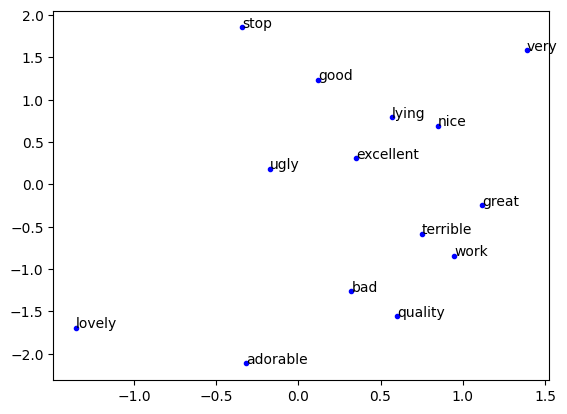

In [ ]:
# 학습 후 임베딩 결과
import matplotlib.pyplot as plt
weights = model.embedding.weight.detach().cpu().numpy()

for idx in range(2, len(tokenizer.vocab)):
    d1, d2 = weights[idx]
    plt.plot(d1, d2, 'b.')
    plt.annotate(tokenizer.decode(idx), (d1, d2))

## 06-013 장치 적용


In [ ]:
# 장치 적용
x = x.to(device)
y = y.to(device)

## 06-014 모델 학습 및 손실 계산


In [ ]:
loss_fn = nn.BCELoss()  # 손실 함수
optimizer = optim.Adam(model.parameters())  # 최적화 도구(optimizer)

epochs = 30000  # 최대 에폭 지정
results = {'cost':[]}

model.train()  # 학습 모드 설정

for epoch in range(epochs):
    h = model(x)  # 예측 값 생성(추론)
    loss = loss_fn(h, y)  # 손실 계산

    optimizer.zero_grad()  # 미분 값 초기화
    loss.backward()  # 역전파(미분 계산)
    optimizer.step()  # 업데이트 진행

    results['cost'].append(loss.item())

    if epoch % 1000 == 0:
        print(f'epoch: {epoch:4d}, cost: {results["cost"][-1]:.10f}')

epoch:    0, cost: 0.8336126208
epoch: 1000, cost: 0.0999854505
epoch: 2000, cost: 0.0096470211
epoch: 3000, cost: 0.0027971684
epoch: 4000, cost: 0.0011345538
epoch: 5000, cost: 0.0005321924
epoch: 6000, cost: 0.0002693047
epoch: 7000, cost: 0.0001423986
epoch: 8000, cost: 0.0000773963
epoch: 9000, cost: 0.0000428017
epoch: 10000, cost: 0.0000239753
epoch: 11000, cost: 0.0000135434
epoch: 12000, cost: 0.0000076884
epoch: 13000, cost: 0.0000043999
epoch: 14000, cost: 0.0000025218
epoch: 15000, cost: 0.0000014369
epoch: 16000, cost: 0.0000008620
epoch: 17000, cost: 0.0000004852
epoch: 18000, cost: 0.0000002816
epoch: 19000, cost: 0.0000001721
epoch: 20000, cost: 0.0000000771
epoch: 21000, cost: 0.0000000630
epoch: 22000, cost: 0.0000000289
epoch: 23000, cost: 0.0000000399
epoch: 24000, cost: 0.0000000033
epoch: 25000, cost: 0.0000000019
epoch: 26000, cost: 0.0000000012
epoch: 27000, cost: 0.0000000007
epoch: 28000, cost: 0.0000000005
epoch: 29000, cost: 0.0000000003


## 06-015 예측 값을 클래스로 변환


In [ ]:
# 예측 값 생성
with torch.no_grad():
    model.eval()
    h = model(x)

# 예측 값(시그모이드 값)을 클래스로 변환
pred = (h.reshape(-1).cpu() > 0.5).to(torch.float32)

print(f'실제 값: {y.reshape(-1)}')
print(f'예측 값: {pred}')

실제 값: tensor([1., 0., 0., 1., 1., 0., 1.], device='cuda:0')
예측 값: tensor([1., 0., 0., 1., 1., 0., 1.])


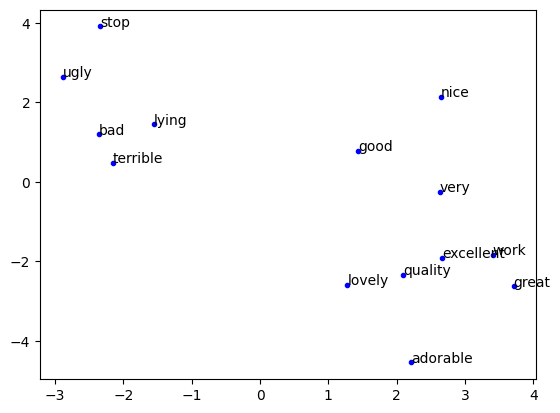

In [ ]:
# 학습 후 임베딩 결과
import matplotlib.pyplot as plt
weights = model.embedding.weight.detach().cpu().numpy()

for idx in range(2, len(tokenizer.vocab)):
    d1, d2 = weights[idx]
    plt.plot(d1, d2, 'b.')
    plt.annotate(tokenizer.decode(idx), (d1, d2))

> 본 자료는 “AI Essential”과정 참여자만을 위해 제공되는 교육용 목적 자료이며, 본 자료의 전체 또는 일부를 무단 복제, 배포, 전송, 수정, 대여 등 일체의 행위는 저작권법, 부정경쟁방지 및 영업비밀보호법 등에 의거하여 엄격히 금지되며 이를 위반하는 경우 관련 법령에 따른 처벌이 수반될 수 있습니다.   